In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import pprint
import sys
import pathlib
parent_path = pathlib.Path.cwd().parent
sys.path.append(str(parent_path))
import socket
import time

from simpleByteProtocol import simpleRecv, simpleSend
from util import MESSAGE_TYPE, pprintResult, loadJsonResult
import krr
import oue
import olh

In [4]:
sns.set()

## DecideSharedParameters

- 大体カテゴリ数の50倍~100倍くらいあれば近似精度は十分そう
- イプシロンが小さいと近似精度が低い傾向

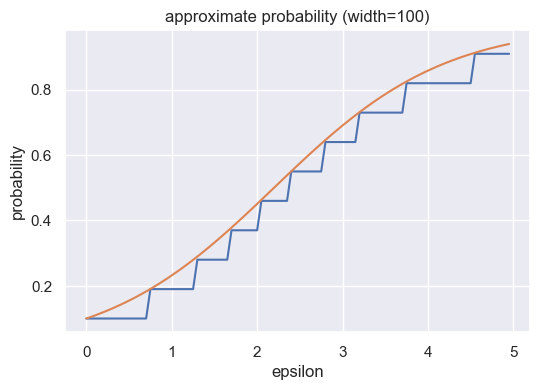

In [5]:
epsilon = 5
width = 100
cate_num = 10
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': []}
correct_data = {'epsilon': [], 'probability': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n, z = krr.buildKrrParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    ratio = np.exp(eps) / ((d-1) + np.exp(eps))
    correct_data['epsilon'].append(eps)
    correct_data['probability'].append(ratio)

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", data=data, ax=ax1)
sns.lineplot(x="epsilon", y="probability", data=correct_data, ax=ax1)
ax1.set_title('approximate probability (width=%d)'% width)
plt.show()
fig.savefig('dsp-width100-cate10.png')

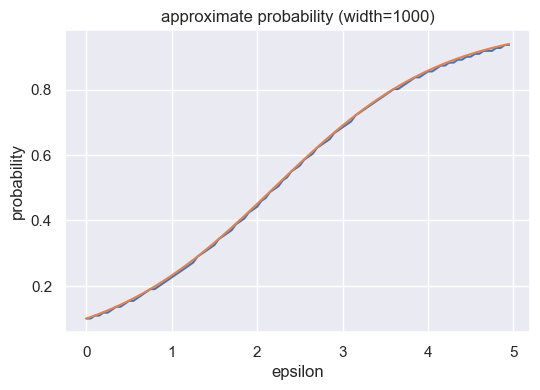

In [6]:
epsilon = 5
width = 1000
cate_num = 10
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': []}
correct_data = {'epsilon': [], 'probability': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n, z = krr.buildKrrParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    ratio = np.exp(eps) / ((d-1) + np.exp(eps))
    correct_data['epsilon'].append(eps)
    correct_data['probability'].append(ratio)

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", data=data, ax=ax1)
sns.lineplot(x="epsilon", y="probability", data=correct_data, ax=ax1)
ax1.set_title('approximate probability (width=%d)'% width)
plt.show()
fig.savefig('dsp-width1000-cate10.png')

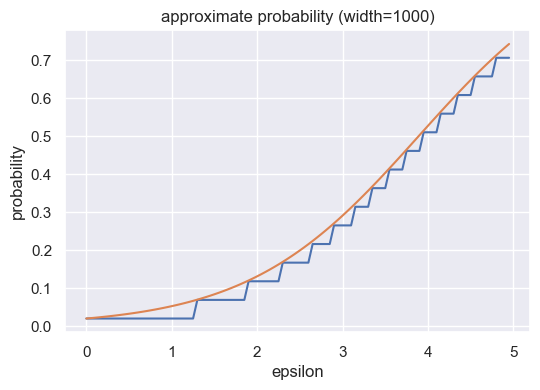

In [7]:
epsilon = 5
width = 1000
cate_num = 50
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': []}
correct_data = {'epsilon': [], 'probability': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n, z = krr.buildKrrParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    ratio = np.exp(eps) / ((d-1) + np.exp(eps))
    correct_data['epsilon'].append(eps)
    correct_data['probability'].append(ratio)

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", data=data, ax=ax1)
sns.lineplot(x="epsilon", y="probability", data=correct_data, ax=ax1)
ax1.set_title('approximate probability (width=%d)'% width)
plt.show()
fig.savefig('dsp-width1000-cate50.png')

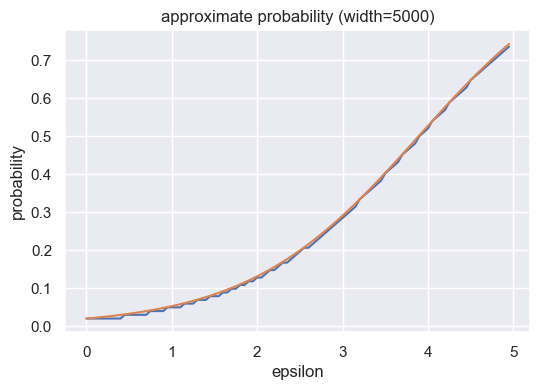

In [8]:
epsilon = 5
width = 5000
cate_num = 50
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': []}
correct_data = {'epsilon': [], 'probability': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n, z = krr.buildKrrParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    ratio = np.exp(eps) / ((d-1) + np.exp(eps))
    correct_data['epsilon'].append(eps)
    correct_data['probability'].append(ratio)

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", data=data, ax=ax1)
sns.lineplot(x="epsilon", y="probability", data=correct_data, ax=ax1)
ax1.set_title('approximate probability (width=%d)'% width)
plt.show()
fig.savefig('dsp-width5000-cate50.png')

## Methods KRR, OUE, OLH

In [37]:
def grouping(results):
    grouped_results = {key: [] for key in results[0].keys()}
    for result in results:
        for k,v in result.items():
            grouped_results[k].append(v)
    return grouped_results

def mean(grouped_results):
    mean_results = {}
    for k, v in grouped_results.items():
        mean_results[k] = np.mean(v)
    return mean_results

def std(grouped_results):
    mean_results = {}
    for k, v in grouped_results.items():
        mean_results[k] = np.std(v)
    return mean_results

In [38]:
# krr
cate_num = 8
epsilon = 1.0
width = 1000
mech = 'krr'
role = 'verifier'
params = [role, cate_num, epsilon, width, mech]
results = loadJsonResult('../result', params)

In [39]:
grouped_results = grouping(results)
print(mean(grouped_results))
print(std(grouped_results))

{'setup time [s]': 0.009633223215738932, 'MESSAGE_TYPE.START size [B]': 52.0, 'step2 time [s]': 0.012579547034369575, 'MESSAGE_TYPE.STEP2 size [B]': 226974.77777777778, 'step4 time [s]': 1.143513282140096, 'MESSAGE_TYPE.STEP4 size [B]': 385865.22222222225, 'overall time': 2.753883123397827}
{'setup time [s]': 0.007009322619250078, 'MESSAGE_TYPE.START size [B]': 0.0, 'step2 time [s]': 0.0010809120453440747, 'MESSAGE_TYPE.STEP2 size [B]': 1451.2249062068433, 'step4 time [s]': 0.03449535569794745, 'MESSAGE_TYPE.STEP4 size [B]': 2192.44788498953, 'overall time': 0.07630109726966088}
